### 실험 내용

---

- 입력 이미지, 텍스트(KeyBERT 결과)의 각 인스턴스에 대해 각각 DB와 거리 계산 수행
- 이미지 카테고리의 인스턴스와 텍스트 카테고리의 인스턴스끼리 평균 거리 반환
- 각 DB요소 별 이미지, 텍스트 거리를 가중치에 따라 병합하여 검색 수행

**DB에서 검색하는 조건 벡터를 모델에 부족한 정보량에 부합하도록 검색 조건을 강화**


In [ ]:
!pip install faiss-cpu
!pip install keybert
!pip install --upgrade sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 25.8 MB/s eta 0:00:00


In [ ]:
import faiss
import json
import  torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd

import os
import io
import requests
from PIL import Image
import PIL
from google.colab import files
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

In [ ]:
# 임베딩 CLIP 모델 정보
model_name = "openai/clip-vit-large-patch14"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)


# text 임베딩 벡터 반환
def encode_text(text, list_tf = False):
    if list_tf:
      inputs = processor(text=text, return_tensors="pt", padding=True)
    else:
      inputs = processor(text=[text], return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = clip_model.get_text_features(**inputs)

    text_features = torch.nn.functional.normalize(text_features, p=2, dim=-1) #정규화

    return text_features.cpu().numpy().astype("float32")

# 검색
def search_similar_images(vector, image_index, top_k=5):
    distances, indices = image_index.search(vector, top_k) # 벡터 검색

    return indices, distances

# 병합
def distance_merge(ind_list, dis_list): # 인덱스에 따라 거리 평균 반환
  num = len(ind_list)
  return_dict = dict()
  for ind, dis in zip(ind_list, dis_list):
    for key, value in zip(ind, dis):
      if key not in return_dict:
        return_dict[key] = 0
      return_dict[key] += value
  result = {key: value / num for key, value in return_dict.items()}

  return list(result.keys()), list(result.values())


def final_dis(text, image_list, image_index_db, top_k, tf = False, tw=0.5, iw=0.5):
  if tf :
    text_vec = encode_text(text, True) # 텍스트 가 리스트인 경우
  else:
    text_vec = encode_text(text) # 텍스트 벡터

  # 이미지 벡터
  inputs = processor(images=image_list, return_tensors="pt")

  with torch.no_grad():
    image_features = clip_model.get_image_features(**inputs)

  image_features = torch.nn.functional.normalize(image_features, p=2, dim=-1) #정규화

  # 전체 DB에서 검색 수행
  image_index, image_dis = search_similar_images(image_features, image_index_db, 1326)
  text_index, text_dis = search_similar_images(text_vec, image_index_db, 1326)

  # 입력 이미지, 텍스트의 거리 평균 반환
  total_image_index, total_image_dis = distance_merge(image_index, image_dis)
  total_text_index, total_text_dis = distance_merge(text_index, text_dis)

  # 거리에 가중치 적용
  total_image_dis = [e * iw for e in total_image_dis]
  total_text_dis = [e * tw for e in total_text_dis]


  # 최종 거리 계산
  return_dict = dict()
  for ind, dis in zip([total_image_index, total_text_index], [total_image_dis, total_text_dis]):
    for key, value in zip(ind, dis):
      if key not in return_dict:
        return_dict[key] = 0
      return_dict[key] += value


  final_index, final_dis = list(return_dict.keys()), list(return_dict.values()) #최종 인덱스, 거리 반환

  # argsort를 사용하여 오름차순 인덱스 반환
  sorted_indices = np.argsort(final_dis)[:top_k] #  k 개

  final_index_sort = [final_index[i] for i in sorted_indices] # 해당 위치 DB인덱스 반환

  # 임베딩 벡터
  image_embed_vectors = []
  for i in final_index_sort:  # 이차원 배열이므로 첫 번째 row에서 가져오기
    vec = np.zeros((image_index_db.d,), dtype=np.float32)  # 빈 벡터 생성
    image_index_db.reconstruct(int(i), vec)  # 특정 ID의 벡터 복원
    image_embed_vectors.append(vec) # 저장

  image_embed = torch.tensor(np.array(image_embed_vectors), dtype=torch.float32)

  return image_embed, [final_dis[i] for i in sorted_indices]


In [ ]:
# 이미지 입력 받기

upload_dir = "/content/uploads"
os.makedirs(upload_dir, exist_ok=True)

# 업로드된 이미지 경로 저장
uploaded_image_paths = []

# Colab에서 이미지 파일 업로드 및 저장
def upload_images():
    uploaded_files = files.upload()
    for file_name in uploaded_files.keys():
        file_path = os.path.join("/content", file_name)  # 기본 업로드 경로
        move_path = os.path.join(upload_dir, file_name)  # 사용자 지정 디렉토리

        # 파일을 원하는 디렉토리로 이동
        os.rename(file_path, move_path)

        uploaded_image_paths.append(move_path)
        print(f"save image : {move_path}")


# 버튼 설정
upload_button = widgets.Button(description="이미지 업로드")

# 클릭 시 실행
def on_upload_clicked(b):
    upload_images()


upload_button.on_click(on_upload_clicked)

# 출력
display(upload_button)


Button(description='이미지 업로드', style=ButtonStyle())

Saving 강아지 목줄 올려다봄.jpg to 강아지 목줄 올려다봄.jpg
save image : /content/uploads/강아지 목줄 올려다봄.jpg


Saving 목줄 착용샷.jpg to 목줄 착용샷.jpg
save image : /content/uploads/목줄 착용샷.jpg


In [ ]:
# DB 설정

faiss_index_filename = "/content/dog_ad.index"


# FAISS 인덱스 로드
db_index = faiss.read_index(faiss_index_filename)

In [ ]:

# 텍스트 입력
query_text = "This stylish dog collar combines navy fabric with beige leather details. Featuring a gold-tone buckle and a matching tag. The dog wearing the collar, sits on a cushion, gazing at its owner with loving eyes."
input_images = [Image.open(path).convert("RGB") for path in uploaded_image_paths] # 입력 이미지 리스트


top_k = 3 # 최근접 이웃 개수



In [ ]:
# 키워드 추출 코드
from keybert import KeyBERT

# 모델 로드
kw_model = KeyBERT()


# 키워드 추출
keywords = kw_model.extract_keywords(query_text,
                                     keyphrase_ngram_range=(2, 4),
                                     stop_words='english',
                                     use_mmr=True,
                                     top_n=3)

print("추출된 키워드:", keywords)

texts = []
w = []

# 추출 키워드 가중치 계산
for tup in keywords:
  texts.append(tup[0]) # 키워드
  w.append(tup[1] * 0.45) # 가중치 계산

print(texts, w)



In [ ]:
# 유사한 이미지 벡터 검색
similar_images_emb, distances = final_dis(texts, input_images, db_index, top_k=top_k, tf = True, tw=0.7, iw=0.3)

print(distances)

weights = np.array([(1/d)+1e-6 for d in distances]) # 거리 기준으로 계산

# 정규화 (합이 1이 되도록)
normalized_weights = weights / np.sum(weights) * 0.4
top_k_w = normalized_weights.tolist() # 가중치를 list 타입
print(top_k_w)

[254.14360605875652, 254.14360605875652, 256.2139976501465]
[0.13369335434536953, 0.13369335434536953, 0.13261329130926094]


생성

In [ ]:
### 라이브러리 파일 교체

import os
from google.colab import files

# 교체할 파일 경로
file_path = "/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/kandinsky/pipeline_kandinsky_prior.py"

# 파일 업로드
uploaded_files = files.upload()

# 업로드된 파일 처리
for file_name in uploaded_files.keys():
    # 업로드된 파일이 Python 파일인지 확인
    if file_name.endswith(".py"):
        upload_file_path = os.path.join("/content", file_name)  # Colab 기본 업로드 경로

        # 파일을 diffusers 경로로 이동하여 덮어쓰기
        os.rename(upload_file_path, file_path)

        print(f"업로드 완료")
    else:
        print(f"ERROR")



Saving pipeline_kandinsky_prior_up.py to pipeline_kandinsky_prior_up.py
업로드 완료


In [ ]:
from diffusers import KandinskyPriorPipeline, KandinskyPipeline

# 모델 불러오기
pipe_prior = KandinskyPriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-1-prior", torch_dtype=torch.float16
)
pipe_prior.to("cuda")


pipe = KandinskyPipeline.from_pretrained("kandinsky-community/kandinsky-2-1", torch_dtype=torch.float16)
pipe.to("cuda")


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/767 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/271M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

movq%2Fconfig.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

tokenizer%2Ftokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/318 [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You are using a model of type xlm-roberta to instantiate a model of type M-CLIP. This is not supported for all configurations of models and can yield errors.


KandinskyPipeline {
  "_class_name": "KandinskyPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "kandinsky-community/kandinsky-2-1",
  "movq": [
    "diffusers",
    "VQModel"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "kandinsky",
    "MultilingualCLIP"
  ],
  "tokenizer": [
    "transformers",
    "XLMRobertaTokenizerFast"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ]
}

In [ ]:
# 텍스트 가중치
query_text_w = 0.3
cond_image_w = 0.6
# 생성 이미지 개수
num_images_per_prompt = 2

# image_text 컨디션 리스트

images_texts = texts + input_images

# 가중치 설정
weights = w + [0.3, 0.3] #[cond_image_w/(len(input_images)) for _ in input_images]
# 이 뒷부분 [cond_image_w/(len(input_images)) for _ in input_images] 영역은
# 이미지 개수에 맞게 직접 설정 가능 [0.3, 0.5] 이런 식

prompt = query_text
prior_out = pipe_prior.interpolate(images_texts,
                                   weights,
                                   search_k=True,
                                   top_k_image = similar_images_emb.to("cuda", dtype=torch.float16),
                                   top_k_w =top_k_w)

"""
변수 설명
image_text : 이미지+텍스트 컨디션 리스트
weight : 이미지+텍스트 컨디션 가중치
search_k : 최근접 이미지 k를 삽입할 것인지 여부 (bool)
top_k_image : 찾은 최근접 이미지 벡터
top_k_w : 최근접 이미지 가중치
"""


new_image_add = pipe(prompt, **prior_out, height=768, width=768, num_images_per_prompt=num_images_per_prompt).images
#prior_out은 image_embs + negative image embs로 구성됨
# 여기서도  매개변수 지정 가능
"""
num_images_per_prompt : 생성할 이미지 개수
guidance_scale : prompt 집중 정도
"""
if num_images_per_prompt > 1:
  plt.figure(figsize=(15,8))
  for i in range(len(new_image_add)):
    plt.subplot(round(len(new_image_add)/2), 2, i+1)
    plt.imshow(new_image_add[i])
    plt.axis('off')
  plt.show()
else:
  plt.imshow(new_image_add)
  plt.axis('off')
  plt.show()



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
torch.Size([1, 768])
add top k image
8
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

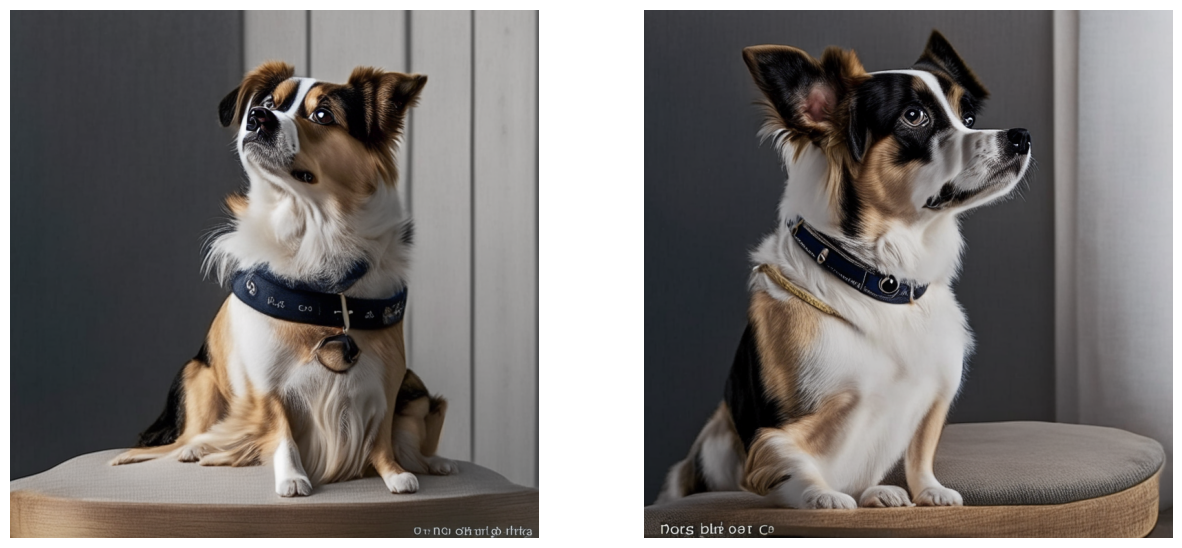

In [ ]:
# 텍스트 가중치
query_text_w = 0.3
cond_image_w = 0.6
# 생성 이미지 개수
num_images_per_prompt = 2

# image_text 컨디션 리스트

images_texts = ['dog collar combines navy fabric', 'dog', 'sits cushion gazing owner'] + input_images

# 가중치 설정
weights = [0.34771500000000005, 0.238185, 0.11830500000000001] + [0.3, 0.3] #[cond_image_w/(len(input_images)) for _ in input_images]
# 이 뒷부분 [cond_image_w/(len(input_images)) for _ in input_images] 영역은
# 이미지 개수에 맞게 직접 설정 가능 [0.3, 0.5] 이런 식

prompt = query_text
prior_out = pipe_prior.interpolate(images_texts,
                                   weights,
                                   search_k=True,
                                   top_k_image = similar_images_emb.to("cuda", dtype=torch.float16),
                                   top_k_w =top_k_w)

"""
변수 설명
image_text : 이미지+텍스트 컨디션 리스트
weight : 이미지+텍스트 컨디션 가중치
search_k : 최근접 이미지 k를 삽입할 것인지 여부 (bool)
top_k_image : 찾은 최근접 이미지 벡터
top_k_w : 최근접 이미지 가중치
"""


new_image_add = pipe(prompt, **prior_out, height=768, width=768, num_images_per_prompt=num_images_per_prompt).images
#prior_out은 image_embs + negative image embs로 구성됨
# 여기서도  매개변수 지정 가능
"""
num_images_per_prompt : 생성할 이미지 개수
guidance_scale : prompt 집중 정도
"""
if num_images_per_prompt > 1:
  plt.figure(figsize=(15,8))
  for i in range(len(new_image_add)):
    plt.subplot(round(len(new_image_add)/2), 2, i+1)
    plt.imshow(new_image_add[i])
    plt.axis('off')
  plt.show()
else:
  plt.imshow(new_image_add)
  plt.axis('off')
  plt.show()



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

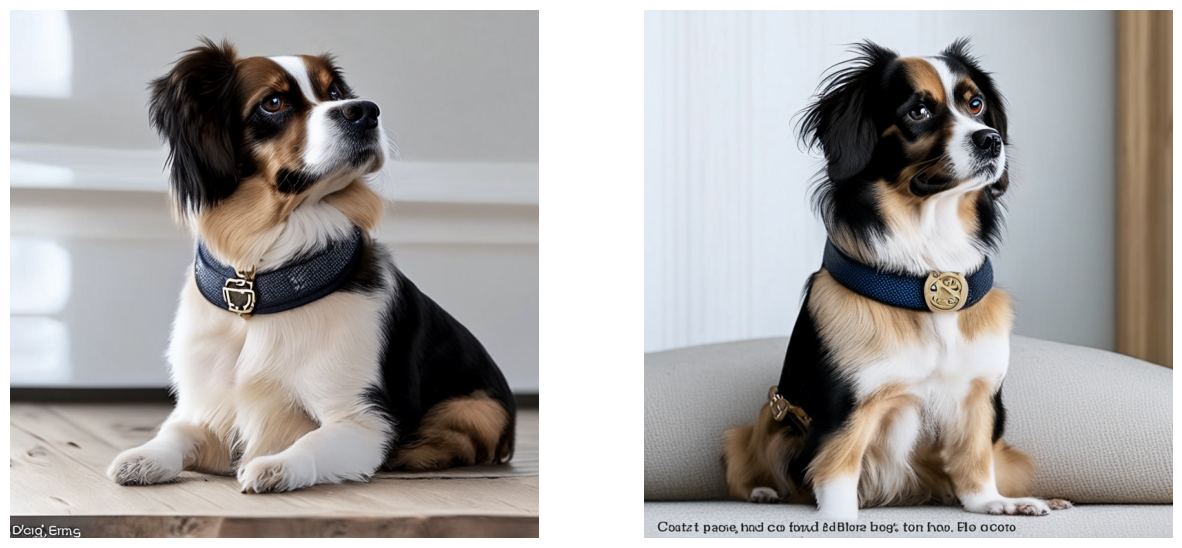

In [ ]:
# 검색 안한 경우

prompt = query_text
prior_out = pipe_prior.interpolate(images_texts,
                                   weights)
"""
변수 설명
image_text : 이미지+텍스트 컨디션 리스트
weight : 이미지+텍스트 컨디션 가중치
search_k : 최근접 이미지 k를 삽입할 것인지 여부 (bool)
top_k_image : 찾은 최근접 이미지 벡터
top_k_w : 최근접 이미지 가중치
"""


new_image_add = pipe(prompt, **prior_out, height=768, width=768, num_images_per_prompt=num_images_per_prompt).images
#prior_out은 image_embs + negative image embs로 구성됨
# 여기서도  매개변수 지정 가능
"""
num_images_per_prompt : 생성할 이미지 개수
guidance_scale : prompt 집중 정도
"""
if num_images_per_prompt > 1:
  plt.figure(figsize=(15, 8))
  for i in range(len(new_image_add)):
    plt.subplot(round(len(new_image_add)/2), 2, i+1)
    plt.imshow(new_image_add[i])
    plt.axis('off')
  plt.show()
else:
  plt.imshow(new_image_add)
  plt.axis('off')
  plt.show()

